In [1]:
import jax
# jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as gp
import hugegp_cuda as gp_cuda

import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

rng = jr.key(99)

In [17]:
def tree_dot(tree1, tree2):
    leaves = jax.tree_util.tree_map(lambda x, y: jnp.dot(x, y), tree1, tree2)
    return jax.tree_util.tree_reduce(lambda x, y: x + y, leaves)

In [2]:
# Set up test
n_points = 1000
k1, k2 = jr.split(rng)
points = jr.normal(k1, (n_points, 2))
xi = jr.normal(k2, (n_points,))
graph = gp.build_graph(points, n0=100, k=8, cuda=True)
cov_bins = gp.make_cov_bins(r_min=1e-3, r_max=10, n_bins=100)
cov_func = gp.MaternCovariance(p=0)
cov_vals = cov_func(cov_bins)

values = gp.generate(graph, (cov_bins, cov_vals), xi, cuda=True)

In [192]:
rng, k1, k2, k3 = jr.split(rng, 4)
cov_vals_tangent = cov_vals * jr.normal(k1, (len(cov_vals),))
xi_tangent = jr.normal(k2, (n_points,))
values_tangent = jr.normal(k3, (n_points,))

func = lambda cov_vals, xi: gp.generate(graph, (cov_bins, cov_vals), xi, cuda=True)

val1 = jnp.dot(values_tangent, jax.jvp(func, (cov_vals, xi), (cov_vals_tangent, xi_tangent))[1])
val2 = tree_dot((cov_vals_tangent, xi_tangent), jax.vjp(func, cov_vals, xi)[1](values_tangent))

print(val1)
print(val2)
print((val1 - val2) / val2)

46.32673
46.326683
9.88121e-07


In [ ]:
# Test adjoint condition
k1, k2, k3, k4 = jr.split(rng, 4)
n_points, graph, covariance = default_setup(k1)
xi = jr.normal(k2, (n_points,))
xi_tangent = jr.normal(k3, (n_points,))
values_tangent = jr.normal(k4, (n_points,))
func = Partial(gp.generate, graph, covariance, cuda=True)

val1 = jnp.dot(values_tangent, jax.jvp(func, (xi,), (xi_tangent,))[1])
val2 = jnp.dot(xi_tangent, jax.vjp(func, xi)[1](values_tangent)[0])

In [36]:
cuda_vjp = jax.vjp(lambda cutoff: gp.generate(graph, (cov_bins, cov_func(cov_bins, cutoff=cutoff)), xi, cuda=True), 0.1)[1](values)
cuda_vjp

(Array(1279.2568, dtype=float32, weak_type=True),)

In [37]:
jax_vjp = jax.vjp(lambda cutoff: gp.generate_jit(graph, (cov_bins, cov_func(cov_bins, cutoff=cutoff)), xi, cuda=False), 0.1)[1](values)
jax_vjp

(Array(1279.2566, dtype=float32, weak_type=True),)

In [41]:
cuda_vjp = jax.vjp(lambda cov_vals: gp.generate(graph, (cov_bins, cov_vals), xi, cuda=True), cov_vals)[1](values)
cuda_vjp

(Array([ 3.2814020e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00, -2.2664065e+00, -3.6071606e-02,  0.0000000e+00,
         0.0000000e+00, -6.2828450e+00, -2.1001444e+00,  1.0863513e+00,
         0.0000000e+00, -1.1525879e+00, -9.3249969e+00, -3.4862332e+00,
         2.2155228e+00, -6.5988350e+00, -1.5245001e+00,  0.0000000e+00,
         6.0174103e+00,  4.7766666e+00, -9.0705276e-01, -1.1885201e+00,
         5.5978155e+00,  2.4601979e+00, -9.3915081e+00, -1.9980427e+01,
        -2.1370857e+01, -1.4296014e+01,  3.9107891e+01,  1.7541393e+01,
         5.8802299e+00,  2.2633853e+00,  9.9433684e-01, -5.2837963e+00,
        -1.3944230e+01,  1.3097131e+01,  3.5965267e+01,  4.2506480e+00,
         1.7754528e+01,  1.8421309e+01, -4.9378319e+00,  1.8118790e+01,
        -3.1099941e+01,  1.7008995e+01, -4.9435673e+00, -6.3729424e+01,
        -4.4304626e+01, -8.3166094e+00,  2.1710234e+01, -9.51942

In [42]:
jax_vjp = jax.vjp(lambda cov_vals: gp.generate_jit(graph, (cov_bins, cov_vals), xi, cuda=False), cov_vals)[1](values)
jax_vjp

(Array([ 3.28139709e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.26633072e+00, -3.60703878e-02,  0.00000000e+00,
         0.00000000e+00, -6.28287792e+00, -2.10007620e+00,  1.08641803e+00,
         0.00000000e+00, -1.15259266e+00, -9.32504272e+00, -3.48625088e+00,
         2.21554470e+00, -6.59887505e+00, -1.52451038e+00,  0.00000000e+00,
         6.01757431e+00,  4.77680588e+00, -9.07054961e-01, -1.18850565e+00,
         5.59782648e+00,  2.46021485e+00, -9.39155197e+00, -1.99803295e+01,
        -2.13709126e+01, -1.42959890e+01,  3.91079865e+01,  1.75413971e+01,
         5.88020277e+00,  2.26345539e+00,  9.94369745e-01, -5.28371811e+00,
        -1.39441414e+01,  1.30970402e+01,  3.59652824e+01,  4.25065470e+00,
         1.77545300e+01,  1.84212933e+01, -4.93795252e+00,  1.81185055e+01,
        -3.10997620e+01,  1.70089054e+01, -4.94330692e+00, -6.37295265e+01,
        -4.4

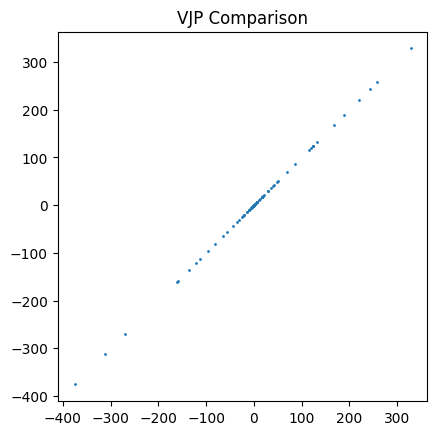

In [43]:
plt.scatter(cuda_vjp, jax_vjp, s=1)
plt.gca().set(aspect='equal', title='VJP Comparison')
plt.show()

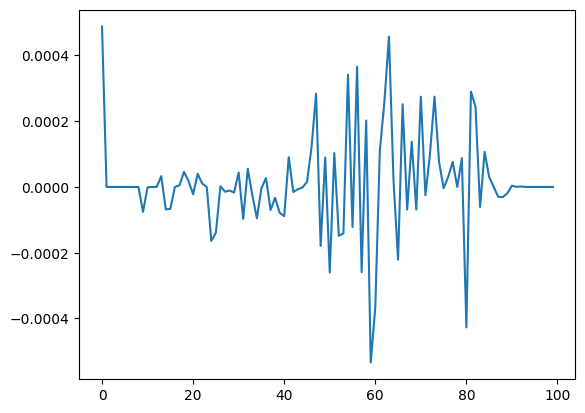

In [44]:
plt.plot(cuda_vjp[0] - jax_vjp[0])

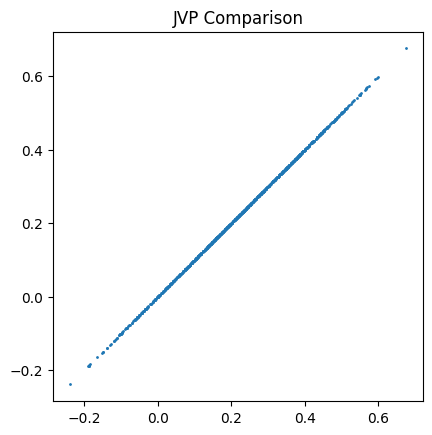

In [6]:
jax_jvp = jax.jvp(lambda cutoff: gp.generate_jit(graph, (cov_bins, cov_func(cov_bins, cutoff=cutoff)), xi, cuda=False), (1.0,), (0.5,))
cuda_jvp = jax.jvp(lambda cutoff: gp.generate(graph, (cov_bins, cov_func(cov_bins, cutoff=cutoff)), xi, cuda=True), (1.0,), (0.5,))
# plt.plot(jax_jvp[1] - cuda_jvp[1])
plt.scatter(cuda_jvp[1], jax_jvp[1], s=1)
plt.gca().set(aspect='equal', title='JVP Comparison')
plt.show()

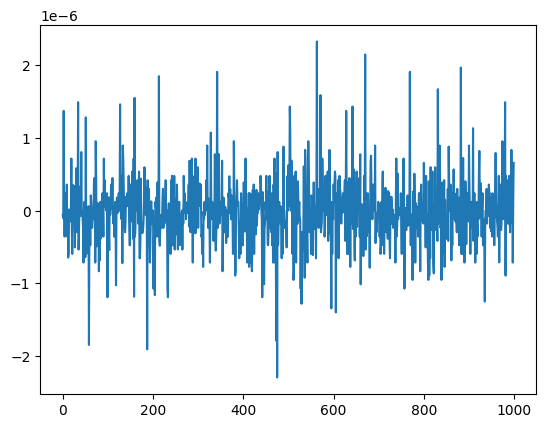

In [21]:
plt.plot(jax_jvp[0] - cuda_jvp[0])

In [7]:
points = jnp.array([0.0, 0.5, 2.0])[:,None]
neighbors = jnp.array([[0, 1]])
offsets = (2, 3)
cov_bins = gp.make_cov_bins(r_min=1e-3, r_max=10, n_bins=100)
cov_func = gp.MaternCovariance(p=0)
cov_vals = cov_func(cov_bins)

rng, k1 = jr.split(rng)
xi = jr.normal(k1, (len(points),))
graph = gp.Graph(points, neighbors, offsets)
initial_values = gp.generate_dense(points[:2], (cov_bins, cov_vals), xi[:2])
values = gp.generate(graph, (cov_bins, cov_vals), xi)
xi = xi[2:]
offsets = jnp.array(offsets)

gp_cuda.primitive.refine_nonlinear_vjp(points, neighbors, offsets, cov_bins, cov_vals, initial_values, xi, values, jnp.ones_like(values))[1:]

(Array([-0.6254356 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.09664513,  0.0

In [8]:
jax.vjp(lambda cov_vals, initial_values, xi: gp.refine(points, neighbors, offsets, (cov_bins, cov_vals), initial_values, xi), cov_vals, initial_values, xi)[1](jnp.ones_like(values))

(Array([-0.6254355 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.09664507,  0.0